### Algorithm

1. Read the dataset.
2. Reshape the dataset
2. Split the dataset to:
    * 70% training (only contain normal data),
    * 10% validation (contain normal and anomaly data), and
    * 20% testing dataset (contain normal and anomaly data)
3. Create autoencoder model.
4. Train the model using training dataset.
5. Validate the model using validation dataset.
6. Test the model using testing dataset.

### Requirements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


### Hyperparameters

In [2]:
window_size = 5
value_range = (0, 40000)

test_size = 0.25
random_state = 11

# Define model's hyperparameters
hidden_size = 64
output_size = 1
num_epochs = 1000
batch_size = 32
learning_rate = 0.001

### Reading dataset

In [3]:
# Read the dataset
df = pd.read_csv('/nas.dbms/mahendra.data/Documents/annotation/NAB/data/realKnownCause/ec2_request_latency_system_failure.csv',low_memory=False)
df['timestamp'] = pd.to_datetime(df['timestamp'])


# The times of anomaly events (Ground Truth)
anomaly_points = [
        [
            "2014-03-14 05:00:00.000000",
            "2014-03-14 12:30:00.000000"
        ],
        [
            "2014-03-18 21:30:00.000000",
            "2014-03-19 00:00:00.000000"
        ],
        [
            "2014-03-21 02:00:00.000000",
            "2014-03-21 03:41:00.000000"
        ]
]

# Normal label: 0, Anomaly label: 1
df['anomaly'] = 0  # Set default values
for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

In [4]:
print(df.head())
print("\nDataset size:")
print(df.shape)
print("\nDataset distribution:")
print(df['anomaly'].value_counts())

            timestamp   value  anomaly
0 2014-03-07 03:41:00  45.868        0
1 2014-03-07 03:46:00  47.606        0
2 2014-03-07 03:51:00  42.580        0
3 2014-03-07 03:56:00  46.030        0
4 2014-03-07 04:01:00  44.992        0

Dataset size:
(4032, 3)

Dataset distribution:
0    3891
1     141
Name: anomaly, dtype: int64


### Split training and testing dataset

In [5]:
def plot_anomaly(df, label='anomaly', plot_item='value', time_col='timestamp', scatter=True):
    plotter =  plt.scatter if scatter else plt.plot  # Plot function
    section_list = list()  # Section list

    # State and starting point of the fist section 
    state = df.iloc[0][label]
    start = 0

    for i in df.index:
        # Do nothing if the state is similar
        if df.loc[i][label] == state:
            continue

        # Create a new section if the state is different
        section = df.loc[start:i].copy(deep=True)  # Create a new section
        section.index = section[time_col]  # Change index
        section_list.append(section)  # Add new section to a list

        # State and starting point of the next section 
        state = df.loc[i][label]  # Change state
        start = i  # Change starting point

    # Create last section
    section = df.loc[start:].copy(deep=True)  # Create the last section
    section.index = section[time_col]  # Change index
    section_list.append(section)  # Add last section to a list

    # Plot
    plt.close()
    plt.figure().set_figwidth(20)
    color = {0: 'blue', 1: 'red'}
    for s in section_list:
        plotter(
            s.index,
            s[plot_item],
            color=color[s.iloc[0][label]]
        )
    plt.show()

(3450, 3)


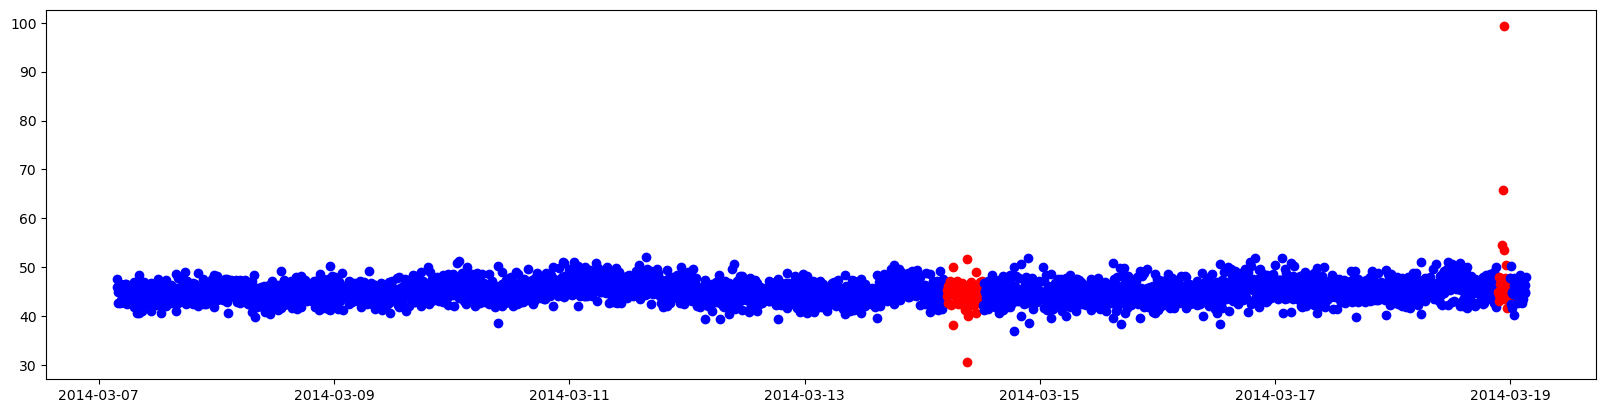

In [6]:
cut = 3450
cut_train = cut // window_size * window_size
df_train = df[:cut_train]  # Select three sections of anomaly for training
print(df_train.shape)
plot_anomaly(df_train)

(580, 3)


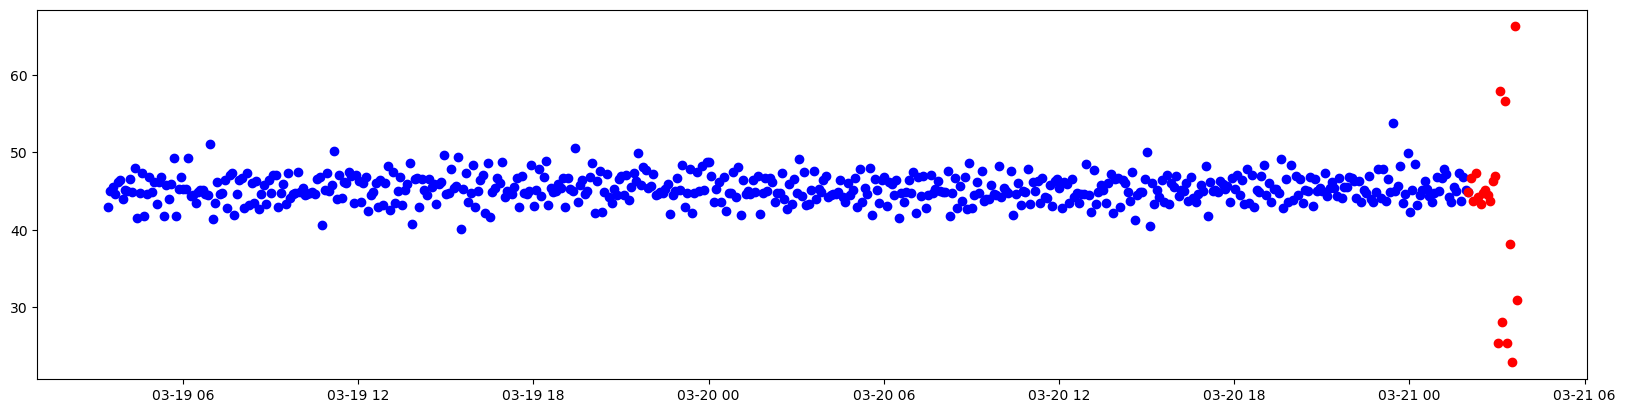

In [7]:
cut_test = df.shape[0] - ((df.shape[0]-cut_train) // window_size * window_size)
df_test = df[cut_test:]  # Select two sections of anomaly for testing
print(df_test.shape)
plot_anomaly(df_test)

### Reshape datasets

In [8]:
def create_dataset(df, window_size, value_range):
    X, y = [], []
    for i in range(df.shape[0]-window_size):
        feature = df['value'].iloc[i:i+window_size]
        target = df['anomaly'].iloc[i:i+window_size]
        X.append(feature)
        y.append(target)

    # Convert to numpy
    X = np.array(X)
    y = np.array(y)

    # Normalization
    X = (X - value_range[0]) / (value_range[1] - value_range[0])

    # Calculate the median of the labels
    y = np.round(np.mean(y, axis=1))

    return X, y


# Create training and testing dataset
X_train, y_train = create_dataset(df_train, window_size, value_range)
X_test, y_test = create_dataset(df_test, window_size, value_range)

In [9]:
print("Training dataset")
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
print("Anomaly distribution:")
print(pd.Series(y_train).value_counts())

print("\nTesting dataset")
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)
print("Anomaly distribution:")
print(pd.Series(y_test).value_counts())

Training dataset
X shape: (3445, 5)
y shape: (3445,)
Anomaly distribution:
0.0    3325
1.0     120
dtype: int64

Testing dataset
X shape: (575, 5)
y shape: (575,)
Anomaly distribution:
0.0    557
1.0     18
dtype: int64


### Training and Testing

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fcOut = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fcOut(out)
        return out


def predict(model, features_tensor):
    with torch.no_grad():
        model.eval()
        train_outputs = model(features_tensor)
        return torch.round(torch.sigmoid(train_outputs)).squeeze().cpu().numpy()


# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Define input size
input_size = X_train.shape[1]

# Create the MLP model
model = MLPClassifier(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

progress_bar = tqdm(range(num_epochs),ncols=150)
progress_bar.set_description("Training")
for epoch in progress_bar:
    # Set the model in training mode
    model.train()

    for batch_features, batch_labels in dataloader:
        # Move batch to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_features)

        # Calculate loss
        loss = criterion(outputs.squeeze(1), batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    progress_bar.set_postfix(Loss="%.4f" % loss.item())


# Train prediction
train_predictions = predict(model, X_train_tensor)

# Test prediction
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
test_predictions = predict(model, X_test_tensor)


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.64it/s, Loss=0.1928]


### Matrix

In [11]:
def show_matrix(y, y_pred):
    ps = precision_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("precision_score: %.2f" % ps)

    rs = recall_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("recall_score: %.2f" % rs)

    f1 = f1_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("f1_score: %.2f" % f1)

    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    ax = sns.heatmap(
        cm, # confusion matrix 2D array 
        annot=True, # show numbers in the cells
        fmt='d', # show numbers as integers
        xticklabels=[0,1],
        yticklabels=[0,1]
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

/nas.dbms/mahendra.data/.userprogram/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_score: 0.00
recall_score: 0.00
f1_score: 0.00


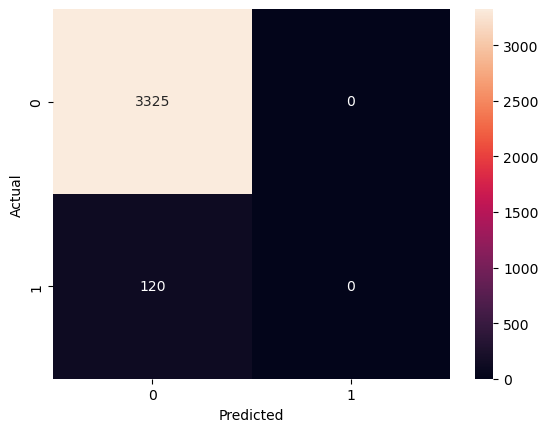

In [12]:
show_matrix(y_train, train_predictions)

/nas.dbms/mahendra.data/.userprogram/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_score: 0.00
recall_score: 0.00
f1_score: 0.00


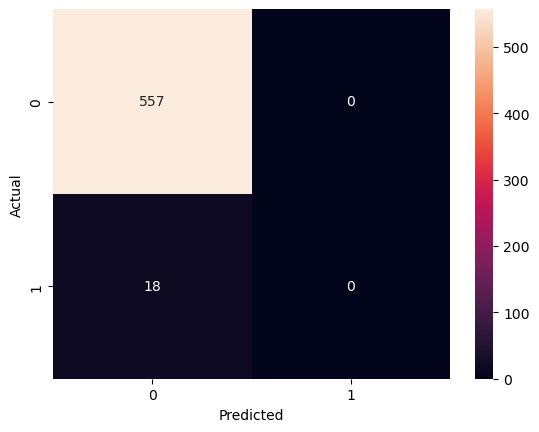

In [13]:
show_matrix(y_test, test_predictions)